<a href="https://colab.research.google.com/github/parvathysarat/pretrained-language-models/blob/master/BERT_QA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install transformers
from transformers import BertForQuestionAnswering
model = BertForQuestionAnswering.from_pretrained('bert-large-uncased-whole-word-masking-finetuned-squad')

     |████████████████████████████████| 778kB 4.0MB/s 
     |████████████████████████████████| 3.0MB 22.7MB/s 
     |████████████████████████████████| 1.1MB 40.2MB/s 
     |████████████████████████████████| 890kB 47.2MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.43-cp36-none-any.whl size=893260 sha256=e24d2876fee743b2de988832409f3d880737ed6faa5380d9a113ed9b888a2391
  Stored in directory: /root/.cache/pip/wheels/29/3c/fd/7ce5c3f0666dab31a50123635e6fb5e19ceb42ce38d4e58f45
Successfully built sacremoses


In [ ]:
from transformers import BertTokenizer

tokenizer = BertTokenizer.from_pretrained('bert-large-uncased-whole-word-masking-finetuned-squad')

In [ ]:
import torch

In [ ]:
question = "How many parameters does BERT-large have?"
answer_text = "BERT-large is really big... it has 24-layers and an embedding size of 1,024, for a total of 340M parameters! Altogether it is 1.34GB, so expect it to take a couple minutes to download to your Colab instance."

In [ ]:
input_ids = tokenizer.encode(question, answer_text)
print(f"The input has a total of {len(input_ids)} tokens.")
print(input_ids)
?tokenizer.encode

The input has a total of 70 tokens.
[101, 2129, 2116, 11709, 2515, 14324, 1011, 2312, 2031, 1029, 102, 14324, 1011, 2312, 2003, 2428, 2502, 1012, 1012, 1012, 2009, 2038, 2484, 1011, 9014, 1998, 2019, 7861, 8270, 4667, 2946, 1997, 1015, 1010, 6185, 2549, 1010, 2005, 1037, 2561, 1997, 16029, 2213, 11709, 999, 10462, 2009, 2003, 1015, 1012, 4090, 18259, 1010, 2061, 5987, 2009, 2000, 2202, 1037, 3232, 2781, 2000, 8816, 2000, 2115, 15270, 2497, 6013, 1012, 102]


In [ ]:
tokens = tokenizer.convert_ids_to_tokens(input_ids)
print(tokens)
print(tokenizer.sep_token,"token id :",tokenizer.sep_token_id)

['[CLS]', 'how', 'many', 'parameters', 'does', 'bert', '-', 'large', 'have', '?', '[SEP]', 'bert', '-', 'large', 'is', 'really', 'big', '.', '.', '.', 'it', 'has', '24', '-', 'layers', 'and', 'an', 'em', '##bed', '##ding', 'size', 'of', '1', ',', '02', '##4', ',', 'for', 'a', 'total', 'of', '340', '##m', 'parameters', '!', 'altogether', 'it', 'is', '1', '.', '34', '##gb', ',', 'so', 'expect', 'it', 'to', 'take', 'a', 'couple', 'minutes', 'to', 'download', 'to', 'your', 'cola', '##b', 'instance', '.', '[SEP]']
[SEP] token id : 102


In [ ]:
# get first index of [SEP] token
# tokenizer.sep_token_id = '[SEP]'
sep_index = input_ids.index(tokenizer.sep_token_id)

num_seg_a = sep_index + 1

num_seg_b = len(input_ids) - num_seg_a

segment_ids = [0]*num_seg_a + [1]*num_seg_b

# ensure there is a segment_id for every input token
assert len(segment_ids) == len(input_ids)

In [ ]:
## feed our example into the BERT model
start_scores, end_scores = model(torch.tensor([input_ids]),
                                 token_type_ids = torch.tensor([segment_ids])) # segment_ids differentiate b/w q & a

answer_start = torch.argmax(start_scores)
answer_end = torch.argmax(end_scores)

answer = ' '.join(tokens[answer_start:answer_end + 1])

answer = tokens[answer_start]

# Select the remaining answer tokens and join them with whitespace.
for i in range(answer_start + 1, answer_end + 1):
    
    # If it's a subword token, then recombine it with the previous token.
    if tokens[i][0:2] == '##':
        answer += tokens[i][2:]
    
    # Otherwise, add a space then the token.
    else:
        answer += ' ' + tokens[i]

print('Answer: "' + answer + '"')


Answer: "340m"


### Start-word score visualization

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style='darkgrid')

# Increase the plot size and font size.
#sns.set(font_scale=1.5)

plt.rcParams["figure.figsize"] = (16,8)
# Pull the scores out of PyTorch Tensors and convert them to 1D numpy arrays.
s_scores = start_scores.detach().numpy().flatten()

# We'll use the tokens as the x-axis labels. In order to do that, they all need
# to be unique, so we'll add the token index to the end of each one.
token_labels = []
for (i, token) in enumerate(tokens):
    token_labels.append('{:} - {:>2}'.format(token, i))

def plot_start_scores(start_scores):

  sns.set(font_scale=1.0)

  plt.rcParams["figure.figsize"] = (16,8)
  # Pull the scores out of PyTorch Tensors and convert them to 1D numpy arrays.
  s_scores = start_scores.detach().numpy().flatten()

  # We'll use the tokens as the x-axis labels. In order to do that, they all need
  # to be unique, so we'll add the token index to the end of each one.
  token_labels = []
  for (i, token) in enumerate(tokens):
      token_labels.append('{:} - {:>2}'.format(token, i))  
  # Use plot styling from seaborn.
  # Create a barplot showing the start word score for all of the tokens.
  ax = sns.barplot(x=token_labels, y=s_scores, ci=None)

  # Turn the xlabels vertical.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=90, ha="center")

  # Turn on the vertical grid to help align words to scores.
  ax.grid(True)

  plt.title('Start Word Scores')

  plt.show()

### End-word score visualization

In [ ]:
def plot_end_scores(end_scores):
  e_scores = end_scores.detach().numpy().flatten()
  sns.set(font_scale=1.0)

  plt.rcParams["figure.figsize"] = (16,8)
  # Pull the scores out of PyTorch Tensors and convert them to 1D numpy arrays.
  s_scores = start_scores.detach().numpy().flatten()

  # We'll use the tokens as the x-axis labels. In order to do that, they all need
  # to be unique, so we'll add the token index to the end of each one.
  token_labels = []
  for (i, token) in enumerate(tokens):
      token_labels.append('{:} - {:>2}'.format(token, i))  

  # Create a barplot showing the end word score for all of the tokens.
  ax = sns.barplot(x=token_labels, y=e_scores, ci=None)

  # Turn the xlabels vertical.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=90, ha="center")

  # Turn on the vertical grid to help align words to scores.
  ax.grid(True)

  plt.title('End Word Scores')

  plt.show()

## Modular QA Function

In [ ]:
def answer_question(question, answer_text):
    '''
    Takes a `question` string and an `answer_text` string (which contains the
    answer), and identifies the words within the `answer_text` that are the
    answer. Prints them out.
    '''
    # ======== Tokenize ========
    # Apply the tokenizer to the input text, treating them as a text-pair.
    input_ids = tokenizer.encode(question, answer_text)

    # Report how long the input sequence is.
    print('Query has {:,} tokens.\n'.format(len(input_ids)))

    # ======== Set Segment IDs ========
    # Search the input_ids for the first instance of the `[SEP]` token.
    sep_index = input_ids.index(tokenizer.sep_token_id)

    # The number of segment A tokens includes the [SEP] token istelf.
    num_seg_a = sep_index + 1

    # The remainder are segment B.
    num_seg_b = len(input_ids) - num_seg_a

    # Construct the list of 0s and 1s.
    segment_ids = [0]*num_seg_a + [1]*num_seg_b

    # There should be a segment_id for every input token.
    assert len(segment_ids) == len(input_ids)

    # ======== Evaluate ========
    # Run our example question through the model.
    start_scores, end_scores = model(torch.tensor([input_ids]), # The tokens representing our input text.
                                    token_type_ids=torch.tensor([segment_ids])) # The segment IDs to differentiate question from answer_text

    # ======== Reconstruct Answer ========
    # Find the tokens with the highest `start` and `end` scores.
    answer_start = torch.argmax(start_scores)
    answer_end = torch.argmax(end_scores)

    # Get the string versions of the input tokens.
    tokens = tokenizer.convert_ids_to_tokens(input_ids)

    # Start with the first token.
    answer = tokens[answer_start]

    # Select the remaining answer tokens and join them with whitespace.
    for i in range(answer_start + 1, answer_end + 1):
        
        # If it's a subword token, then recombine it with the previous token.
        if tokens[i][0:2] == '##':
            answer += tokens[i][2:]
        
        # Otherwise, add a space then the token.
        else:
            answer += ' ' + tokens[i]

    print('Answer: "' + answer + '"')
    return start_scores, end_scores

In [ ]:
import textwrap

# wrap to 80 characters to print paragraph
wrapper = textwrap.TextWrapper(width=80) 

bert_abstract = "We introduce a new language representation model called BERT, which stands for Bidirectional Encoder Representations from Transformers. Unlike recent language representation models (Peters et al., 2018a; Radford et al., 2018), BERT is designed to pretrain deep bidirectional representations from unlabeled text by jointly conditioning on both left and right context in all layers. As a result, the pre-trained BERT model can be finetuned with just one additional output layer to create state-of-the-art models for a wide range of tasks, such as question answering and language inference, without substantial taskspecific architecture modifications. BERT is conceptually simple and empirically powerful. It obtains new state-of-the-art results on eleven natural language processing tasks, including pushing the GLUE score to 80.5% (7.7% point absolute improvement), MultiNLI accuracy to 86.7% (4.6% absolute improvement), SQuAD v1.1 question answering Test F1 to 93.2 (1.5 point absolute improvement) and SQuAD v2.0 Test F1 to 83.1 (5.1 point absolute improvement)."

print(wrapper.fill(bert_abstract))

We introduce a new language representation model called BERT, which stands for
Bidirectional Encoder Representations from Transformers. Unlike recent language
representation models (Peters et al., 2018a; Radford et al., 2018), BERT is
designed to pretrain deep bidirectional representations from unlabeled text by
jointly conditioning on both left and right context in all layers. As a result,
the pre-trained BERT model can be finetuned with just one additional output
layer to create state-of-the-art models for a wide range of tasks, such as
question answering and language inference, without substantial taskspecific
architecture modifications. BERT is conceptually simple and empirically
powerful. It obtains new state-of-the-art results on eleven natural language
processing tasks, including pushing the GLUE score to 80.5% (7.7% point absolute
improvement), MultiNLI accuracy to 86.7% (4.6% absolute improvement), SQuAD v1.1
question answering Test F1 to 93.2 (1.5 point absolute improvement) 

In [ ]:
question = "What does the 'B' in BERT stand for?"

start_scores, end_scores = answer_question(question, bert_abstract)

Query has 258 tokens.

Answer: "bidirectional encoder representations from transformers"


In [ ]:
alcon_abstract = "Nestlé of Switzerland purchased Alcon in 1977.[6] Alcon expanded its manufacturing capability with new plants in South America and Europe and drastically increased its investment in research.In 1979, Alcon acquired Texas Pharmacal Company which became Dermatological Products of Texas (and is now DPT Laboratories).[7]In 1984, Alcon founded the Technical Excellence Award to promote achievements in R&D excellence and has awarded it to more than 100 recipients"
print(wrapper.fill(alcon_abstract))
question1 = "Technical Excellence Award is related to which company?"
question2 = "Technical Excellence Award is related to which department?"
question3 = "did nestle purchase alcon?"

start_scores, end_scores = answer_question(question2, alcon_abstract)


Nestlé of Switzerland purchased Alcon in 1977.[6] Alcon expanded its
manufacturing capability with new plants in South America and Europe and
drastically increased its investment in research.In 1979, Alcon acquired Texas
Pharmacal Company which became Dermatological Products of Texas (and is now DPT
Laboratories).[7]In 1984, Alcon founded the Technical Excellence Award to
promote achievements in R&D excellence and has awarded it to more than 100
recipients
Query has 106 tokens.

Answer: "r & d"


## Start-Word Scores and End-Word Scores Visualization

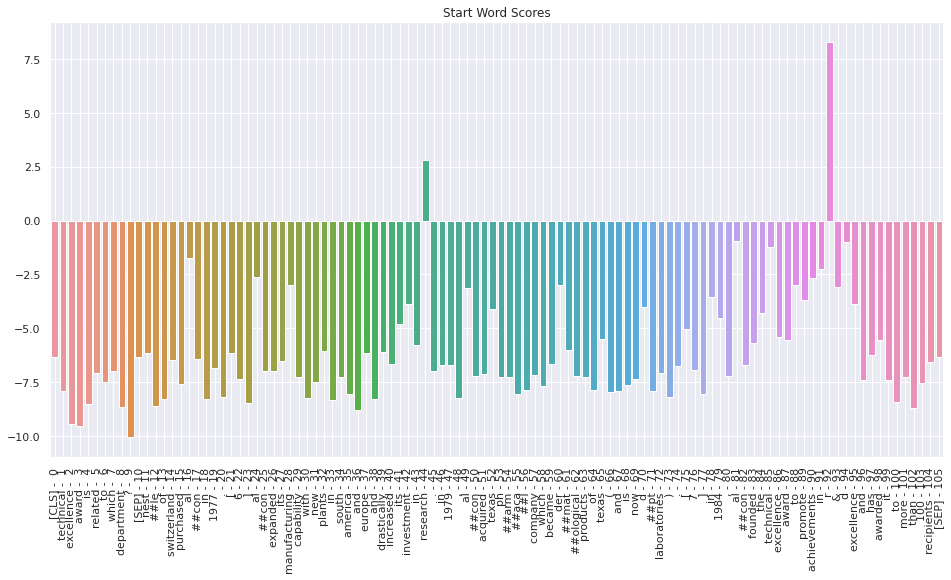

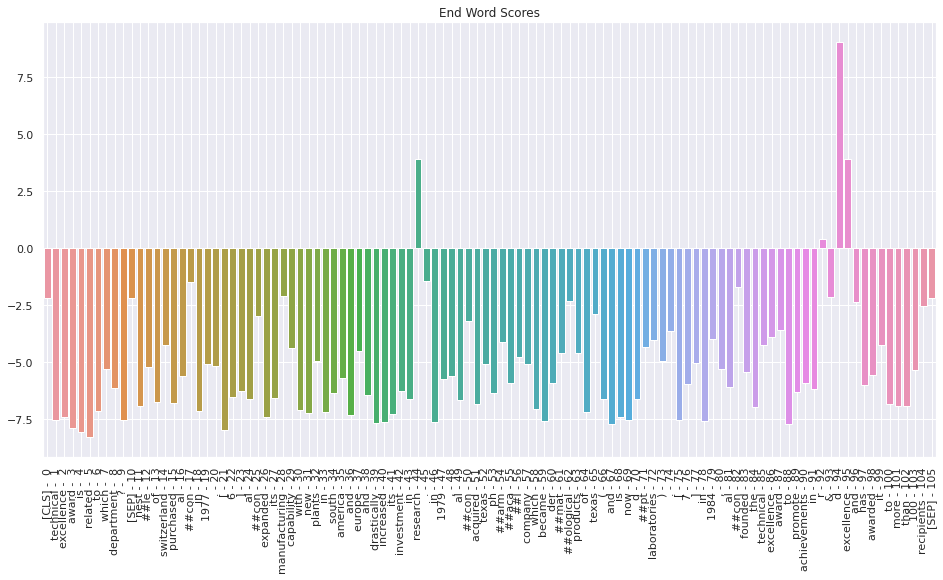

In [ ]:
input_ids = tokenizer.encode(question2, alcon_abstract)
tokens = tokenizer.convert_ids_to_tokens(input_ids)
plot_start_scores(start_scores)
plot_end_scores(end_scores)

In [ ]:
start_scores
end_scores

tensor([[-2.1636, -7.5413, -7.4006, -7.8631, -8.0613, -8.2961, -7.1588, -5.2837,
         -6.1513, -7.5144, -2.1635, -6.9110, -5.2170, -6.7532, -4.2348, -6.8015,
         -5.5878, -1.5015, -7.1437, -5.0768, -5.1618, -7.9909, -6.5064, -6.2809,
         -6.5962, -2.9802, -7.4045, -6.5690, -2.0984, -4.3849, -7.0923, -7.2338,
         -4.9248, -7.1759, -6.3385, -5.6738, -7.3311, -4.5000, -6.4535, -7.6764,
         -7.6369, -7.2906, -6.2733, -6.6243,  3.9191, -1.4326, -7.6289, -5.7193,
         -5.6030, -6.6667, -3.1933, -6.8369, -5.0653, -6.3346, -4.0976, -5.9048,
         -4.7886, -5.0887, -7.0528, -7.5724, -5.8976, -4.5905, -2.2968, -4.6018,
         -7.1884, -2.9025, -6.6103, -7.6969, -7.4056, -7.5413, -6.6056, -4.3172,
         -4.0204, -4.9455, -3.6430, -7.5518, -5.9334, -5.0276, -7.5587, -3.9883,
         -5.2927, -6.0647, -1.7225, -5.4103, -6.9707, -4.2654, -3.8842, -3.5808,
         -7.7152, -6.3263, -5.9054, -6.1672,  0.4088, -2.1360,  9.0355,  3.8895,
         -2.3529, -5.9844, -